In [101]:
# HW
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt
import pylab as pl
from pandas import *

In [102]:
import numpy as np
import pandas as pd

In [103]:
import datetime as dt

# Reflect Tables into SQLAlchemy ORM

In [104]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func, inspect, between

In [105]:
engine = create_engine("sqlite:///Resources/hawaii.sqlite")

In [106]:
# reflect an existing database into a new model
Base = automap_base()
# reflect the tables
Base.prepare(engine, reflect=True)

In [107]:
# We can view all of the classes that automap found
Base.classes.keys()

['measurement', 'station']

In [108]:
# Save references to each table
Measurement = Base.classes.measurement
Station = Base.classes.station

In [109]:
# Create our session (link) from Python to the DB
session = Session(engine)
inspector = inspect(engine)
inspector.get_table_names()

['measurement', 'station']

In [110]:
# Use Inspector to print the column names and types
columns = inspector.get_columns('measurement')
for c in columns:
    print(c['name'], c["type"])

id INTEGER
station TEXT
date TEXT
prcp FLOAT
tobs FLOAT


In [111]:
columns = inspector.get_columns('station')
for c in columns:
    print(c['name'], c["type"])

id INTEGER
station TEXT
name TEXT
latitude FLOAT
longitude FLOAT
elevation FLOAT


In [112]:
inspector.get_columns('measurement')[2]

{'name': 'date',
 'type': TEXT(),
 'nullable': True,
 'default': None,
 'autoincrement': 'auto',
 'primary_key': 0}

In [113]:
# Earliest Date
early= session.query(Measurement.date).order_by(Measurement.date).first()
early

('2010-01-01')

In [114]:
# Latest Date
latest_date = session.query(Measurement.date).order_by(Measurement.date.desc()).first()
latest_date

('2017-08-23')

In [115]:
#Calculating previous 12 months Date from the latest date in  the table. 
Twelve_mon = dt.date(2017, 8, 23) - dt.timedelta(days=365)
print(Twelve_mon)

2016-08-23


# Exploratory Climate Analysis

In [116]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results
# Calculate the date 1 year ago from the last data point in the database

# Perform a query to retrieve the data and precipitation scores

# Save the query results as a Pandas DataFrame and set the index to the date column
pres = session.query(Measurement.date, Measurement.prcp).filter(Measurement.date > Twelve_mon).order_by(Measurement.date).all()
pres_df = pd.DataFrame(pres)

# Sort the dataframe by date
pres_df.sort_values("date", axis = 0, ascending = True, inplace = True)

pres_df.head()


,date,prcp
0,2016-08-24,0.08
1,2016-08-24,2.15
2,2016-08-24,2.28
3,2016-08-24,NaN
4,2016-08-24,1.22


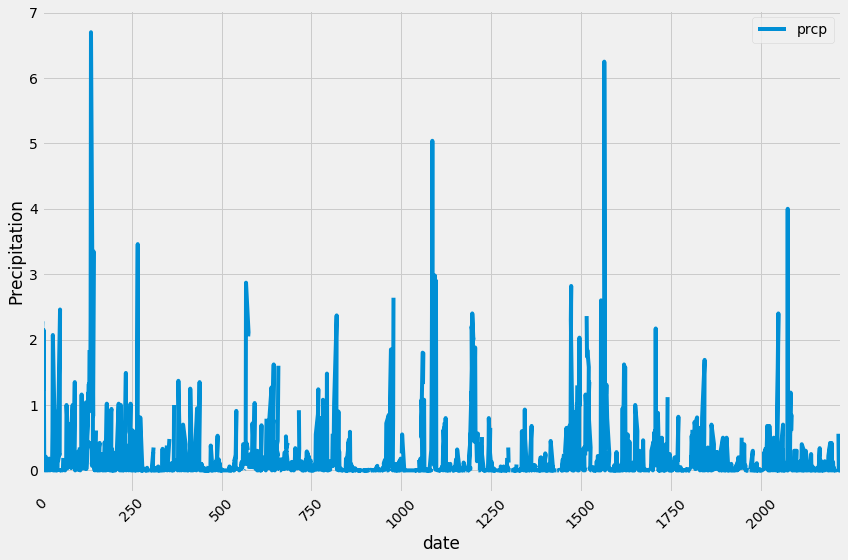

In [117]:
# Use Pandas Plotting with Matplotlib to plot the data
pres_df.plot(x_compat=True, figsize=(12,8))

# Rotate the xticks for the dates
plt.ylabel("Precipitation")
plt.xlabel("date")
plt.xticks(rotation='45')
plt.tight_layout()
plt.show()


In [118]:
#Saving the figure
plt.savefig("Graphs/Data_Prcp.png")

<Figure size 432x288 with 0 Axes>

![precipitation](Images/precipitation.png)

In [119]:
# Use Pandas to calcualte the summary statistics for the precipitation data
pres_df.describe()
pres_df

,date,prcp
0,2016-08-24,0.08
1,2016-08-24,2.15
2,2016-08-24,2.28
3,2016-08-24,NaN
4,2016-08-24,1.22
...,...,...
2218,2017-08-22,0.50
2221,2017-08-23,0.08
2219,2017-08-23,0.00
2220,2017-08-23,0.00


![describe](Images/describe.png)

In [120]:
# Design a query to show how many stations are available in this dataset?
station_count = session.query(Station.id).count()
station_count

9

In [121]:
# What are the most active stations? (i.e. what stations have the most rows)?
session.query(Measurement.station, func.count(Measurement.station)).\
    group_by(Measurement.station).order_by(func.count(Measurement.station).desc()).all()
# List the stations and the counts in descending order.


[('USC00519281', 2772),
 ('USC00519397', 2724),
 ('USC00513117', 2709),
 ('USC00519523', 2669),
 ('USC00516128', 2612),
 ('USC00514830', 2202),
 ('USC00511918', 1979),
 ('USC00517948', 1372),
 ('USC00518838', 511)]

In [122]:
# Using the station id from the previous query, calculate the lowest temperature recorded, 


# highest temperature recorded, and average temperature of the most active station?
session.query(Measurement.tobs, func.min(Measurement.tobs), func.max(Measurement.tobs), func.avg(Measurement.tobs) ).\
    filter(Measurement.station == 'USC00519281').all()



[(85.0, 54.0, 85.0, 71.66378066378067)]

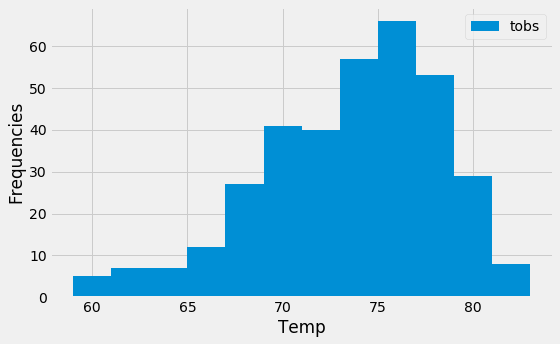

In [123]:
# Choose the station with the highest number of temperature observations.
# Query the last 12 months of temperature observation data for this station and 
station_highest=session.query(Measurement.tobs).\
    filter(Measurement.station == 'USC00519281').filter(Measurement.date >= '2016-08-23').all()
#plot the results as a histogram

station_highest_df=pd.DataFrame(station_highest, columns=['tobs'], )
station_highest_df.plot.hist(bins=12, figsize=(8,5))
pl.xlabel("Temp")
pl.ylabel("Frequencies")
plt.tight_layout()
plt.show()



In [124]:
#Saving the Graph
plt.savefig("Graphs/Temp_histo.png")

<Figure size 432x288 with 0 Axes>

![precipitation](Images/station-histogram.png)

In [125]:
# This function called `calc_temps` will accept start date and end date in the format '%Y-%m-%d' 
# and return the minimum, average, and maximum temperatures for that range of dates
def calc_temps(start_date, end_date):
    """TMIN, TAVG, and TMAX for a list of dates.
    
    Args:
        start_date (string): A date string in the format %Y-%m-%d
        end_date (string): A date string in the format %Y-%m-%d
        
    Returns:
        TMIN, TAVE, and TMAX
    """
    
    return session.query(func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)).\
        filter(Measurement.date >= start_date).filter(Measurement.date <= end_date).all()

# function usage example
print(calc_temps('2012-02-28', '2012-03-05'))

[(62.0, 69.57142857142857, 74.0)]


In [133]:
# Use your previous function `calc_temps` to calculate the tmin, tavg, and tmax 
# for your trip using the previous year's data for those same dates.
trip_start = dt.date(2017, 1, 10)
trip_end = dt.date(2017, 1, 20)
prev_start = trip_start - dt.timedelta(days=365)
prev_end = trip_end - dt.timedelta(days=365)

calc_temp= calc_temps(prev_start, prev_end)
calc_temp

[(61.0, 68.58461538461539, 77.0)]

/Users/saba/anaconda3/envs/PythonData/lib/python3.6/site-packages/ipykernel_launcher.py:16: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  app.launch_new_instance()


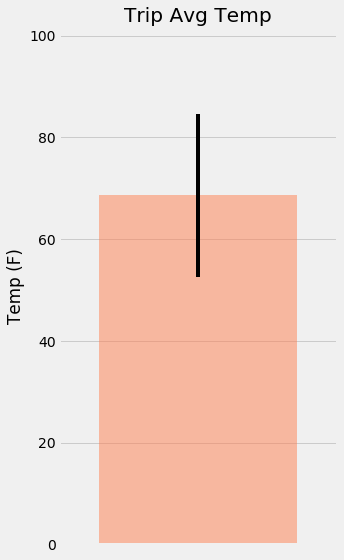

In [161]:
# Plot the results from your previous query as a bar chart. 
calc_temp_df = pd.DataFrame({'tmin': 61.0,
                             'tavg':68.58461538461539, 
                             'tmax': 77.0 }, index = [0]) 

# Use "Trip Avg Temp" as your Title
fig, ax = plt.subplots(figsize= (5,8))

error = calc_temp_df['tmax'] - calc_temp_df['tmin']
avg_temp = calc_temp_df['tavg']
x = 1
bar= ax.bar(x, avg_temp, yerr=error, alpha=0.5, color='coral', align='center')
ax.set(xticks=range(x), xticklabels="a", title="Trip Avg Temp", ylabel="Temp (F)")
ax.margins(.2, .2)
fig.tight_layout()
fig.show()
# Use the average temperature for the y value
# Use the peak-to-peak (tmax-tmin) value as the y error bar (yerr)





In [162]:
#Saving the Figure:
plt.savefig("Graphs/Trip_temp.png")

<Figure size 432x288 with 0 Axes>

In [163]:
# Calculate the total amount of rainfall per weather station for your trip dates using the previous year's matching dates.
# Sort this in descending order by precipitation amount and list the station, name, latitude, longitude, and elevation

trip_start = '2017-01-10'
trip_end = '2017-01-20'

sel = [Station.station, Station.name, Station.latitude, Station.longitude, Station.elevation, func.sum(Measurement.prcp)]
result = session.query(*sel).\
    filter(Measurement.station == Station.station).\
    filter(Measurement.date >= trip_start).\
    filter(Measurement.date <= trip_end).\
    group_by(Station.name).order_by(func.sum(Measurement.prcp).desc()).all()
print (result)

[('USC00516128', 'MANOA LYON ARBO 785.2, HI US', 21.3331, -157.8025, 152.4, 0.08), ('USC00519281', 'WAIHEE 837.5, HI US', 21.45167, -157.84888999999998, 32.9, 0.03), ('USC00519523', 'WAIMANALO EXPERIMENTAL FARM, HI US', 21.33556, -157.71139, 19.5, 0.0), ('USC00519397', 'WAIKIKI 717.2, HI US', 21.2716, -157.8168, 3.0, 0.0), ('USC00517948', 'PEARL CITY, HI US', 21.3934, -157.9751, 11.9, 0.0), ('USC00514830', 'KUALOA RANCH HEADQUARTERS 886.9, HI US', 21.5213, -157.8374, 7.0, 0.0), ('USC00513117', 'KANEOHE 838.1, HI US', 21.4234, -157.8015, 14.6, 0.0)]


## Optional Challenge Assignment

In [164]:
# Create a query that will calculate the daily normals 
# (i.e. the averages for tmin, tmax, and tavg for all historic data matching a specific month and day)

def daily_normals(date):
    """Daily Normals.
    
    Args:
        date (str): A date string in the format '%m-%d'
        
    Returns:
        A list of tuples containing the daily normals, tmin, tavg, and tmax
    
    """
    
    sel = [func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)]
    return session.query(*sel).filter(func.strftime("%m-%d", Measurement.date) == date).all()
    
daily_normals("01-01")

[(62.0, 69.15384615384616, 77.0)]

In [201]:
# calculate the daily normals for your trip
# push each tuple of calculations into a list called `normals`

# Set the start and end date of the trip
trip_start = '2017-01-10'
trip_end = '2017-01-20'

# Use the start and end date to create a range of dates
date_range = session.query(Measurement.date).filter(Measurement.date >= trip_start).\
            filter(Measurement.date <= trip_end).group_by(Measurement.date).all()
trip_dates = [x[0] for x in date_range]
trip_dates_str= [x[5:] for x in trip_dates]
start_day = trip_dates_str[0]
end_day = trip_dates_str[-1]
# Stip off the year and save a list of %m-%d strings

# Loop through the list of %m-%d strings and calculate the normals for each date
daily_normals = [session.query(func.min(Measurement.tobs),
                       func.avg(Measurement.tobs),
                       func.max(Measurement.tobs)).filter(func.strftime("%m-%d", Measurement.date) >= start_day).\
                       filter(func.strftime("%m-%d", Measurement.date) <= end_day).\
                       group_by(func.strftime("%m-%d", Measurement.date)).all()]

normals = daily_normals[0]
print("Daily Normals for 01-10 to 01-20")
normals

Daily Normals for 01-10 to 01-20


[(62.0, 69.74137931034483, 77.0),
 (57.0, 67.3103448275862, 78.0),
 (57.0, 67.4074074074074, 81.0),
 (57.0, 67.25454545454545, 77.0),
 (58.0, 69.52631578947368, 77.0),
 (56.0, 69.31372549019608, 78.0),
 (54.0, 68.62962962962963, 80.0),
 (61.0, 69.07407407407408, 76.0),
 (57.0, 68.63157894736842, 77.0),
 (60.0, 68.26315789473684, 78.0),
 (61.0, 68.86666666666666, 78.0)]

In [203]:
# Load the previous query results into a Pandas DataFrame and add the `trip_dates` range as the `date` index
normals_df= pd.DataFrame(normals,columns=['tmin', 'tavg', 'tmax'])
normals_df['date']= trip_dates
normals_df['date'] = pd.to_datetime(normals_df['date'], format='%Y-%m-%d')
normals_df.set_index('date',inplace=True)

normals_df

,tmin,tavg,tmax
date,,,
2017-01-10,62.0,69.741379,77.0
2017-01-11,57.0,67.310345,78.0
2017-01-12,57.0,67.407407,81.0
2017-01-13,57.0,67.254545,77.0
2017-01-14,58.0,69.526316,77.0
2017-01-15,56.0,69.313725,78.0
2017-01-16,54.0,68.629630,80.0
2017-01-17,61.0,69.074074,76.0
2017-01-18,57.0,68.631579,77.0


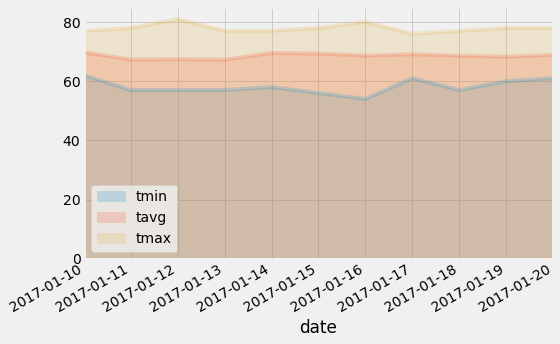

<Figure size 432x288 with 0 Axes>

In [207]:
# Plot the daily normals as an area plot with `stacked=False`
normals_df.plot(kind='area', alpha=.2, stacked=False, x_compat=True, figsize=(8,5))
plt.tight_layout()
plt.show()
plt.savefig("Graphs/DailyNormals.png")
